In [1]:
import shutil
from csv import reader
import numpy as np
import glob
from datetime import datetime
from pyspark.sql import *
from pyspark.sql.functions import col
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pandas as pd
from geopandas.tools import sjoin
import pylab as pl
from pyproj import Proj
import pyproj
%matplotlib inline

In [2]:
yellows = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
                                            inferschema='true').load('yellow_tripdata_2016-01.csv')
first = yellows.take(1)

In [3]:
yellows.registerTempTable("yellow")
print first, yellows.count()

[Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2016, 1, 1, 0, 0), tpep_dropoff_datetime=datetime.datetime(2016, 1, 1, 0, 0), passenger_count=2, trip_distance=1.1, pickup_longitude=-73.99037170410156, pickup_latitude=40.73469543457031, RatecodeID=1, store_and_fwd_flag=u'N', dropoff_longitude=-73.98184204101562, dropoff_latitude=40.73240661621094, payment_type=2, fare_amount=7.5, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=8.8)] 10906858


In [4]:
ind = [1, 2, 5, 6, 9, 10]
selected = map(lambda x: yellows.columns[x], ind)
yellows = yellows.select(selected)

In [5]:
yellows.take(1), yellows.count()

([Row(tpep_pickup_datetime=datetime.datetime(2016, 1, 1, 0, 0), tpep_dropoff_datetime=datetime.datetime(2016, 1, 1, 0, 0), pickup_longitude=-73.99037170410156, pickup_latitude=40.73469543457031, dropoff_longitude=-73.98184204101562, dropoff_latitude=40.73240661621094)],
 10906858)

In [6]:
yellows.write.csv('output1')

In [7]:
# Merging
with open('step1.csv', 'wb') as outpt:
    for name in glob.glob('output1/p*'):
        with open(name, 'rb') as inpt:
            shutil.copyfileobj(inpt, outpt)

In [8]:
with open('step1.csv', 'rb') as inpt:
    step1 = map(lambda row: map(float, row), reader(inpt))

In [9]:
print step1[:5], "\n", len(step1)

[[1453783238000000.0, 1453784014000000.0, -74.01014709472656, 40.72016906738281, -73.97766876220703, 40.74620056152344], [1453783238000000.0, 1453783605000000.0, -73.97068786621094, 40.758941650390625, -73.96082305908203, 40.76491165161133], [1453783238000000.0, 1453783582000000.0, -73.98402404785156, 40.73755645751953, -73.97639465332031, 40.751792907714844], [1453783238000000.0, 1453784614000000.0, -73.9745864868164, 40.76036834716797, -74.01620483398438, 40.7110481262207], [1453783239000000.0, 1453785554000000.0, -73.7801513671875, 40.64728927612305, -73.97257995605469, 40.755855560302734]] 
10906858


In [10]:
starttime = float(datetime.strptime('01/03/2016 12:00:00 AM', '%m/%d/%Y %I:%M:%S %p').strftime('%s')+'000000')
endtime = float(datetime.strptime('01/10/2016 12:00:00 AM', '%m/%d/%Y %I:%M:%S %p').strftime('%s')+'000000')
print starttime, endtime

1.4517972e+15 1.452402e+15


In [11]:
filtered = sorted(filter(lambda row: row[0]<=endtime and row[0]>=starttime, step1), key = lambda x: x[0])

In [12]:
print filtered[0], "\n", filtered[-1], "\n", len(filtered)

[1451797200000000.0, 1451797359000000.0, -73.99823760986328, 40.745426177978516, -73.99474334716797, 40.7501106262207] 
[1452402000000000.0, 1452402712000000.0, -73.9901123046875, 40.719566345214844, -74.00223541259766, 40.73444747924805] 
2473614


In [13]:
ctracts = gpd.GeoDataFrame.from_file('nyct2010.shp')

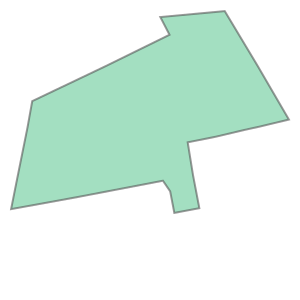

In [14]:
ctracts.iloc[0].geometry

In [15]:
len(np.unique(ctracts['BoroCT2010']))

2166

In [16]:
ctracts = ctracts[['BoroCT2010', 'geometry']]

In [17]:
ctracts.head(2)

,BoroCT2010,geometry
0,5000900,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,1009800,"POLYGON ((994133.507019043 214848.8975830078, ..."


In [18]:
def to_longlat(xy):
    state_plane = pyproj.Proj(init='EPSG:2263', preserve_units=True)
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    lng, lat = pyproj.transform(state_plane, wgs, xy[0], xy[1])
    return (lng, lat)

def to_xy(lnglat):
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    state_plane = pyproj.Proj(init='EPSG:2263', preserve_units=True)
    x, y = pyproj.transform(wgs, state_plane, lnglat[0], lnglat[1])
    return (x, y)

In [19]:
filtered_ = map(lambda rec: [to_xy((rec[2], rec[3])), to_xy((rec[4], rec[5]))], filtered)

In [20]:
filtered_[0]

[(984738.3440194326, 210855.50138421825),
 (985706.4734663767, 212562.23503011954)]

In [21]:
pickdf = pd.DataFrame.from_records(filtered_, columns=['PickLongLat', 'DropLongLat'])
dropdf = pd.DataFrame.from_records(filtered_, columns=['PickLongLat', 'DropLongLat'])

In [22]:
pickdf = pickdf[['PickLongLat']]
dropdf = dropdf[['DropLongLat']]

In [23]:
pickdf.head(3)

,PickLongLat
0,"(984738.344019, 210855.501384)"
1,"(986493.345241, 207119.776894)"
2,"(987710.900226, 209374.199556)"


In [24]:
dropdf.head(3)

,DropLongLat
0,"(985706.473466, 212562.23503)"
1,"(996433.992669, 221971.550758)"
2,"(987105.994913, 211515.827278)"


In [25]:
PickGeom = [Point(xy) for xy in pickdf['PickLongLat']]
DropGeom = [Point(xy) for xy in dropdf['DropLongLat']]

In [26]:
print PickGeom[1]

POINT (986493.3452412838 207119.7768938064)


In [27]:
print DropGeom[1]

POINT (996433.9926685435 221971.5507576292)


In [28]:
pickups = GeoDataFrame(pickdf, crs = {'init': 'EPSG:2263'}, geometry = PickGeom)

In [29]:
dropoffs = GeoDataFrame(dropdf, crs = {'init': 'EPSG:2263'}, geometry = DropGeom)

In [30]:
pickups.head(3)

,PickLongLat,geometry
0,"(984738.344019, 210855.501384)",POINT (984738.3440194326 210855.5013842183)
1,"(986493.345241, 207119.776894)",POINT (986493.3452412838 207119.7768938064)
2,"(987710.900226, 209374.199556)",POINT (987710.9002255326 209374.1995562736)


In [31]:
dropoffs.head(3)

,DropLongLat,geometry
0,"(985706.473466, 212562.23503)",POINT (985706.4734663767 212562.2350301195)
1,"(996433.992669, 221971.550758)",POINT (996433.9926685435 221971.5507576292)
2,"(987105.994913, 211515.827278)",POINT (987105.9949126599 211515.827277733)


In [32]:
ctracts.head(3)

,BoroCT2010,geometry
0,5000900,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,1009800,"POLYGON ((994133.507019043 214848.8975830078, ..."
2,1010000,"POLYGON ((993108.3057861328 216013.1307983398,..."


In [33]:
#pickups.to_csv('pickups.csv')
#dropoffs.to_csv('dropoffs.csv')

In [34]:
ctracts.crs = {'init': 'EPSG:2263'}

In [35]:
print pickups.crs, " ", dropoffs.crs, " ", ctracts.crs

{'init': 'EPSG:2263'}   {'init': 'EPSG:2263'}   {'init': 'EPSG:2263'}


In [36]:
PickTract = sjoin(pickups, ctracts, how = 'right', op = 'intersects')

In [37]:
DropTract = sjoin(dropoffs, ctracts, how = 'right', op = 'intersects')

In [38]:
len(PickTract), len(DropTract)

(2431588, 2426136)

In [39]:
#world = world.to_crs({'init': 'epsg:3395'})
#world.plot();
PickTract.head(3)

,PickLongLat,index_left,BoroCT2010,geometry
index_right,,,,
1689.0,"(984738.344019, 210855.501384)",0.0,1009100,"POLYGON ((986627.8626098633 210628.4536132812,..."
1689.0,"(985696.006909, 210834.692301)",58.0,1009100,"POLYGON ((986627.8626098633 210628.4536132812,..."
1689.0,"(986419.021167, 210713.832136)",157.0,1009100,"POLYGON ((986627.8626098633 210628.4536132812,..."


In [40]:
DropTract.head(3)

,DropLongLat,index_left,BoroCT2010,geometry
index_right,,,,
1849.0,"(985706.473466, 212562.23503)",0.0,1010100,"POLYGON ((987638.8726196289 212444.5310058594,..."
1849.0,"(986571.097875, 212128.679408)",55.0,1010100,"POLYGON ((987638.8726196289 212444.5310058594,..."
1849.0,"(986372.387128, 212141.169571)",71.0,1010100,"POLYGON ((987638.8726196289 212444.5310058594,..."


In [41]:
#del joined['geometry']
#del joined['index_right']

In [42]:
Pickgrouped = PickTract.groupby(['BoroCT2010']).count()
Pickgrouped = Pickgrouped.reset_index()
Dropgrouped = DropTract.groupby(['BoroCT2010']).count()
Dropgrouped = Dropgrouped.reset_index()
Pickgrouped = Pickgrouped[['BoroCT2010', 'geometry']]
Dropgrouped = Dropgrouped[['BoroCT2010', 'geometry']]

In [43]:
Pickgrouped.head(5)

,BoroCT2010,geometry
0,1000100,1
1,1000201,59
2,1000202,135
3,1000500,1
4,1000600,1063


In [44]:
Dropgrouped.head(5)

,BoroCT2010,geometry
0,1000100,1
1,1000201,436
2,1000202,1303
3,1000500,1
4,1000600,1884


In [62]:
# Preparing columns for counting
Pick4plot = Pickgrouped.merge(ctracts, on='BoroCT2010')
Drop4plot = Dropgrouped.merge(ctracts, on='BoroCT2010')
Pick4plot = Pick4plot[['geometry_x', 'geometry_y']]
Drop4plot = Drop4plot[['geometry_x', 'geometry_y']]

In [46]:
Pick4plot.head(3)

,geometry_x,geometry_y
0,1,(POLYGON ((972081.7880249023 190733.4670410156...
1,59,"POLYGON ((988548.2182006836 197770.3748168945,..."
2,135,(POLYGON ((989137.1102294922 196325.4387817383...


In [47]:
Drop4plot.head(3)

,geometry_x,geometry_y
0,1,(POLYGON ((972081.7880249023 190733.4670410156...
1,436,"POLYGON ((988548.2182006836 197770.3748168945,..."
2,1303,(POLYGON ((989137.1102294922 196325.4387817383...


In [48]:
Pick4plot_ = GeoDataFrame(Pick4plot, crs = {'init': 'EPSG:2263'}, geometry = Pick4plot['geometry_y'])
Drop4plot_ = GeoDataFrame(Drop4plot, crs = {'init': 'EPSG:2263'}, geometry = Drop4plot['geometry_y'])

In [49]:
#len(Pick4plot_[Pick4plot['geometry_x']<100])
Pick4plot.describe()

,geometry_x
count,2166.000000
mean,1122.616805
std,4528.796409
min,1.000000
25%,1.000000
50%,4.000000
75%,37.000000
max,66613.000000


In [50]:
print np.min(Pick4plot_.quantile(0)), np.min(Pick4plot_.quantile(0.1))
print np.min(Pick4plot_.quantile(0.2)), np.min(Pick4plot_.quantile(0.4))
print np.min(Pick4plot_.quantile(0.4)), np.min(Pick4plot_.quantile(0.6))
print np.min(Pick4plot_.quantile(0.6)), np.max(Pick4plot_.quantile(0.8))
print np.min(Pick4plot_.quantile(0.8)), np.max(Pick4plot_.quantile(1))

1.0 1.0
1.0 2.0
2.0 7.0
7.0 80.0
80.0 66613.0


In [51]:
Drop4plot.describe()

,geometry_x
count,2166.000000
mean,1120.099723
std,3820.246944
min,1.000000
25%,16.000000
50%,39.000000
75%,205.250000
max,52396.000000


# Pickups plain

/home/denis/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


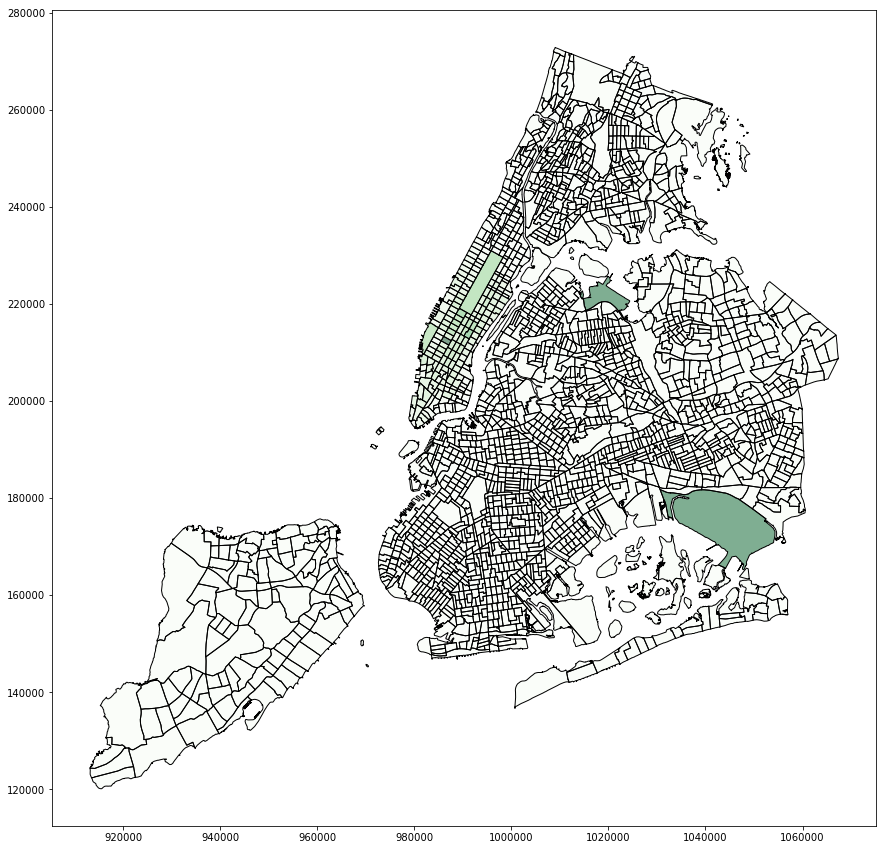

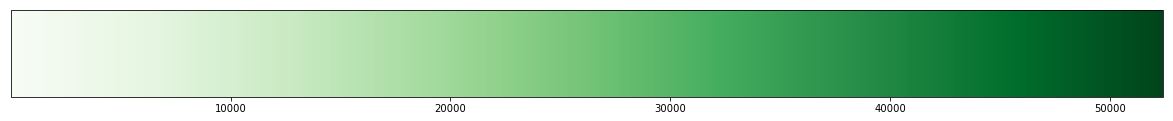

In [52]:
# Pickups choropleth map
plot1 = Pick4plot_.plot(column='geometry_x', colormap='Greens', figsize = (15, 15))
a = np.array([[np.min(Drop4plot_['geometry_x']), np.max(Drop4plot_['geometry_x'])]])
pl.figure(figsize=(20, 2))
img = pl.imshow(a, cmap="Greens")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation = 'horizontal', cax=cax)

# Pickups quantiles

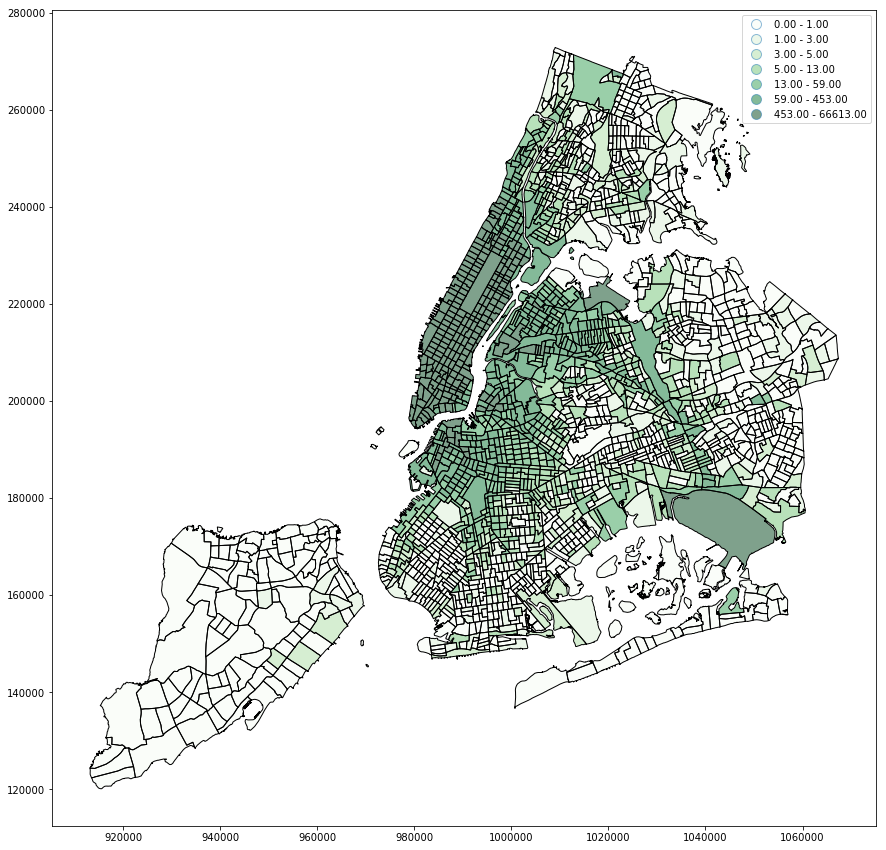

In [53]:
# Pickups choropleth map
plot1 = Pick4plot_.plot(column='geometry_x', scheme='QUANTILES', k=9, colormap='Greens', legend = True,
                        figsize = (15, 15))

# Dropoffs plain

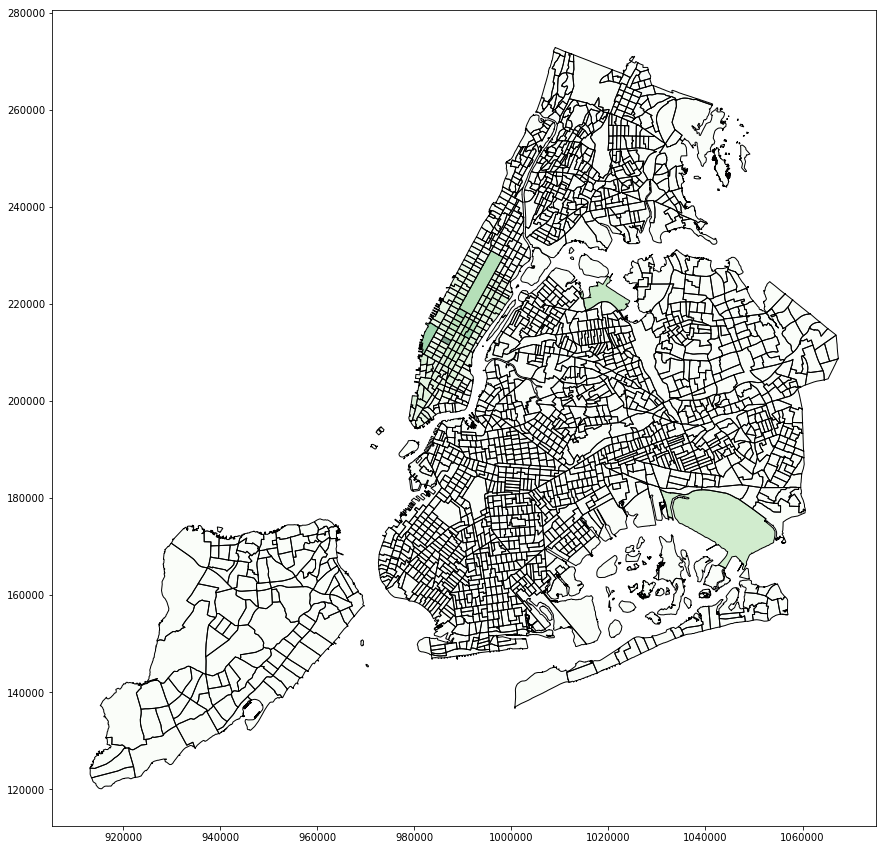

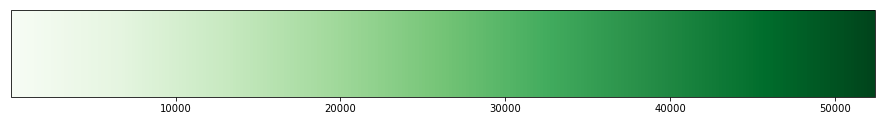

In [54]:
# Dropoffs choropleth map
plot1 = Drop4plot_.plot(column='geometry_x', colormap='Greens', figsize = (15, 15))
a = np.array([[np.min(Drop4plot_['geometry_x']), np.max(Drop4plot_['geometry_x'])]])
pl.figure(figsize=(15, 2))
img = pl.imshow(a, cmap="Greens")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation = 'horizontal', cax=cax)

# Dropoffs quantiles

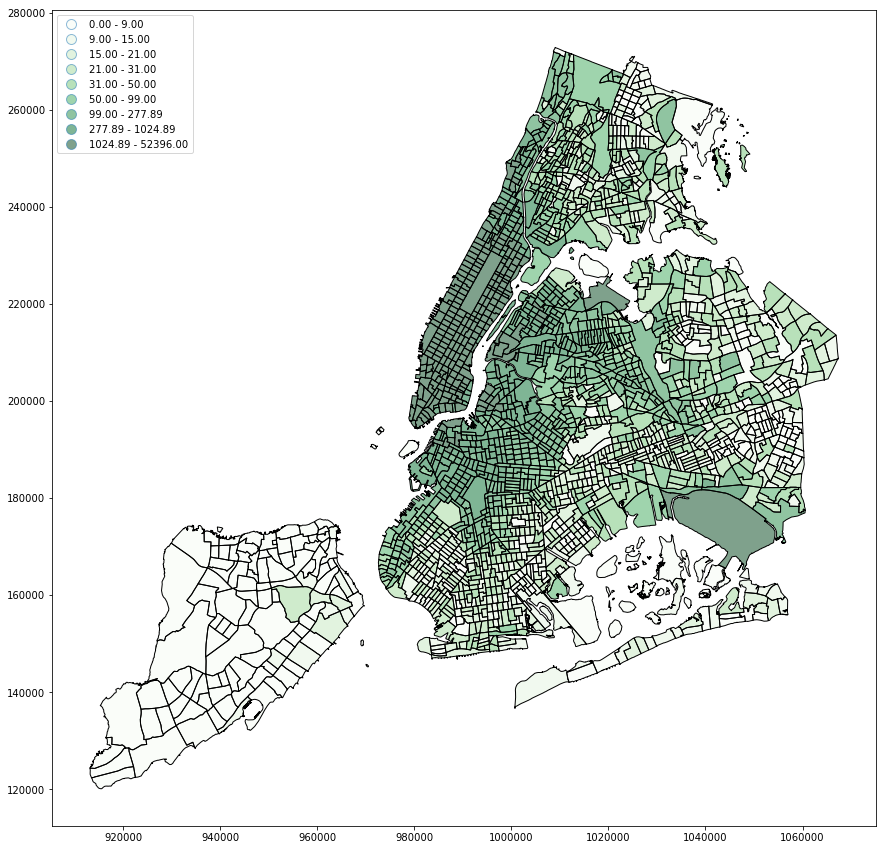

In [55]:
# Dropoffs choropleth map
plot1 = Drop4plot_.plot(column='geometry_x', scheme='QUANTILES', k=9, colormap='Greens', 
                        figsize = (15, 15), legend=True)

In [75]:
ctracts = gpd.GeoDataFrame.from_file('nyct2010.shp')

In [76]:
# Preparing columns for counting
Pick4plot = Pickgrouped.merge(ctracts, on='BoroCT2010')
Drop4plot = Dropgrouped.merge(ctracts, on='BoroCT2010')

In [80]:
Pick4plot = Pick4plot[['BoroCT2010', 'geometry_x', 'BoroCode', 'BoroName', 'CDEligibil', 
                       'CT2010', 'CTLabel', 'NTACode', 'NTAName', 'PUMA']]
Drop4plot = Drop4plot[['BoroCT2010', 'geometry_x', 'BoroCode', 'BoroName', 'CDEligibil', 
                       'CT2010', 'CTLabel', 'NTACode', 'NTAName', 'PUMA']]
Pick4plot = Pick4plot.rename(index = str, columns = {"geometry_x": "Pickups"})
Drop4plot = Drop4plot.rename(index = str, columns = {"geometry_x": "Dropoffs"})

In [81]:
Pick4plot.head(3)

,BoroCT2010,Pickups,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA
0,1000100,1,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810
1,1000201,59,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809
2,1000202,135,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809


In [82]:
Drop4plot.head(3)

,BoroCT2010,Dropoffs,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA
0,1000100,1,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810
1,1000201,436,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809
2,1000202,1303,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809


In [86]:
Pick4plot.to_csv("YellowPickups_Week_01-03-2016.csv")
Drop4plot.to_csv("YellowDropoffs_Week_01-03-2016.csv")

In [125]:
Pick1 = Pick4plot[Pick4plot['Pickups'] >= 1]
Pick1 = Pick1[Pick1['Pickups'] < 3].dropna()
Pick2 = Pick4plot[Pick4plot['Pickups'] >= 3]
Pick2 = Pick2[Pick2['Pickups'] < 5].dropna()
Pick3 = Pick4plot[Pick4plot['Pickups'] >= 5]
Pick3 = Pick3[Pick3['Pickups'] < 13].dropna()
Pick4 = Pick4plot[Pick4plot['Pickups'] >= 13]
Pick4 = Pick4[Pick4['Pickups'] < 59].dropna()
Pick5 = Pick4plot[Pick4plot['Pickups'] >= 59]
Pick5 = Pick5[Pick5['Pickups'] < 453].dropna()
Pick6 = Pick4plot[Pick4plot['Pickups'] >= 453]
Pick6 = Pick6[Pick6['Pickups'] < 66613].dropna()

In [127]:
Pick1.to_csv('Pickups1.csv')
Pick2.to_csv('Pickups2.csv')
Pick3.to_csv('Pickups3.csv')
Pick4.to_csv('Pickups4.csv')
Pick5.to_csv('Pickups5.csv')
Pick6.to_csv('Pickups6.csv')

In [130]:
Drop1 = Drop4plot[Drop4plot['Dropoffs'] >= 0]
Drop1 = Drop1[Drop1['Dropoffs'] < 9].dropna()
Drop2 = Drop4plot[Drop4plot['Dropoffs'] >= 9]
Drop2 = Drop2[Drop2['Dropoffs'] < 15].dropna()
Drop3 = Drop4plot[Drop4plot['Dropoffs'] >= 15]
Drop3 = Drop3[Drop3['Dropoffs'] < 21].dropna()
Drop4 = Drop4plot[Drop4plot['Dropoffs'] >= 21]
Drop4 = Drop4[Drop4['Dropoffs'] < 31].dropna()
Drop5 = Drop4plot[Drop4plot['Dropoffs'] >= 31]
Drop5 = Drop5[Drop5['Dropoffs'] < 50].dropna()
Drop6 = Drop4plot[Drop4plot['Dropoffs'] >= 50]
Drop6 = Drop6[Drop6['Dropoffs'] < 99].dropna()
Drop7 = Drop4plot[Drop4plot['Dropoffs'] >= 99]
Drop7 = Drop7[Drop7['Dropoffs'] < 277].dropna()
Drop8 = Drop4plot[Drop4plot['Dropoffs'] >= 277]
Drop8 = Drop8[Drop8['Dropoffs'] < 1024].dropna()
Drop9 = Drop4plot[Drop4plot['Dropoffs'] >= 1024]
Drop9 = Drop8[Drop8['Dropoffs'] < 52396].dropna()

In [132]:
Drop1.to_csv('Dropoffs1.csv')
Drop2.to_csv('Dropoffs2.csv')
Drop3.to_csv('Dropoffs3.csv')
Drop4.to_csv('Dropoffs4.csv')
Drop5.to_csv('Dropoffs5.csv')
Drop6.to_csv('Dropoffs6.csv')
Drop7.to_csv('Dropoffs7.csv')
Drop8.to_csv('Dropoffs8.csv')
Drop9.to_csv('Dropoffs9.csv')